# Working With STAC - At Scale

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/developmentseed/titiler/master?filepath=docs%2Fexamples%2FWorking_with_STAC.ipynb)

### STAC: SpatioTemporal Asset Catalog

> The SpatioTemporal Asset Catalog (STAC) specification aims to standardize the way geospatial assets are exposed online and queried. A 'spatiotemporal asset' is any file that represents information about the earth captured in a certain space and time. The initial focus is primarily remotely-sensed imagery (from satellites, but also planes, drones, balloons, etc), but the core is designed to be extensible to SAR, full motion video, point clouds, hyperspectral, LiDAR and derived data like NDVI, Digital Elevation Models, mosaics, etc.

Ref: https://github.com/radiantearth/stac-spechttps://github.com/radiantearth/stac-spec

Using STAC makes data indexation and discovery really easy. In addition to the Collection/Item/Asset (data) specifications, data providers are also encouraged to follow a STAC API specification:  https://github.com/radiantearth/stac-api-spec

> The API is compliant with the OGC API - Features standard (formerly known as OGC Web Feature Service 3), in that it defines many of the endpoints that STAC uses. A STAC API should be compatible and usable with any OGC API - Features clients. The STAC API can be thought of as a specialized Features API to search STAC Catalogs, where the features returned are STAC Items, that have common properties, links to their assets and geometries that represent the footprints of the geospatial assets.

### Sentinel 2

Thanks to Digital Earth Africa and in collaboration with Sinergise, Element 84, Amazon Web Services (AWS) and the Committee on Earth Observation Satellites (CEOS), Sentinel 2 (Level 2) data over Africa, usually stored as JPEG2000, has been translated to COG more important a STAC database and API has been setup. 

https://www.digitalearthafrica.org/news/operational-and-ready-use-satellite-data-now-available-across-africa

The API is provided by [@element84](https://www.element84.com) and follows the latest specification: https://earth-search.aws.element84.com/v0


# TiTiler: STAC + COG

Docs: https://github.com/developmentseed/titiler/blob/master/docs/endpoints/stac.md


TiTiler was first designed to work with single COG by passing the file URL to the tiler.
e.g : `https://myendpoint/cog/tiles/1/2/3?url=https://somewhere.com/mycog.tif`

With STAC is a bit different because we first have to read the STAC items and then know which assets to read. 

Example of STAC Item
```
{
    "type": "Feature",
    "id": "S2A_34SGA_20200318_0_L2A",

    "geometry": {...},
    "properties": {
        "datetime": "2020-03-18T09:11:33Z",
        ...
    },
    "collection": "sentinel-s2-l2a-cogs",
    "assets": {
        "thumbnail": {
            "title": "Thumbnail",
            "type": "image/png",
            "href": "https://myurl.com/preview.jpg"
        },
        ...
        "B03": {
            "title": "Band 3 (green)",
            "type": "image/tiff; application=geotiff; profile=cloud-optimized",
            "href": "https://myurl.com/B03.tif",
            "proj:shape": [
                10980,
                10980
            ],
            "proj:transform": [
                10,
                0,
                699960,
                0,
                -10,
                3600000,
                0,-*
                0,
                1
            ]
        },
        ...
    },
    "links": [...]
}
```

To be able to create Web Map tile from the `B03` asset you'll need to pass the STAC Item url and the asset name:

`https://myendpoint/stac/tiles/1/2/3?url=https://somewhere.com/item.json&assets=B03`



## Requirements

To be able to run this notebook you'll need the following requirements:
- rasterio
- ipyleaflet
- requests
- tqdm

`!pip install rasterio ipyleaflet requests tqdm`

In [1]:
import os
import json
import base64
import requests
import datetime
import itertools
import urllib.parse

from io import BytesIO
from functools import partial
from concurrent import futures

from tqdm.notebook import tqdm

from rasterio.plot import reshape_as_image
from rasterio.features import bounds as featureBounds

from ipyleaflet import Map, basemaps, TileLayer, basemap_to_tiles, GeoJSON

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Endpoint variables

titiler_endpoint = "https://api.cogeo.xyz"  # Devseed temporary endpoint
stac_endpoint = "https://earth-search.aws.element84.com/v0/search"

## Search for STAC Items

See https://github.com/radiantearth/stac-api-spec for more documentation about the stac API

1. AOI

You can use geojson.io to define your search AOI

In [3]:
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              30.810813903808594,
              29.454247067148533
            ],
            [
              30.88600158691406,
              29.454247067148533
            ],
            [
              30.88600158691406,
              29.51879923863822
            ],
            [
              30.810813903808594,
              29.51879923863822
            ],
            [
              30.810813903808594,
              29.454247067148533
            ]
          ]
        ]
      }
    }
  ]
}

bounds = featureBounds(geojson)

m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=11
)

geo_json = GeoJSON(data=geojson)
m.add_layer(geo_json)
m

Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

2. Define dates and other filters

In [4]:
start = datetime.datetime.strptime("2019-01-01", "%Y-%m-%d").strftime("%Y-%m-%dT00:00:00Z")
end = datetime.datetime.strptime("2019-12-11", "%Y-%m-%d").strftime("%Y-%m-%dT23:59:59Z")

# POST body
query = {
    "collections": ["sentinel-s2-l2a-cogs"],
    "datetime": f"{start}/{end}",
    "query": {
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    "intersects": geojson["features"][0]["geometry"],
    "limit": 100,
    "fields": {
      'include': ['id', 'properties.datetime', 'properties.eo:cloud_cover'],  # This will limit the size of returned body
      'exclude': ['assets', 'links']  # This will limit the size of returned body
    }
}

# POST Headers
headers = {
    "Content-Type": "application/json",
    "Accept-Encoding": "gzip",
    "Accept": "application/geo+json",
}

data = requests.post(stac_endpoint, headers=headers, json=query).json()
print("Results context:")
print(data["context"])
print()
print("Example of item:")
print(json.dumps(data["features"][0], indent=4))

sceneid = [f["id"] for f in data["features"]]
cloudcover = [f["properties"]["eo:cloud_cover"] for f in data["features"]]
dates = [f["properties"]["datetime"][0:10] for f in data["features"]]

Results context:
{'page': 1, 'limit': 100, 'matched': 85, 'returned': 85}

Example of item:
{
    "bbox": [
        30.155974613579858,
        28.80949327971016,
        31.050481437029678,
        29.815791988006527
    ],
    "geometry": {
        "coordinates": [
            [
                [
                    30.155974613579858,
                    28.80949327971016
                ],
                [
                    30.407037927198104,
                    29.805008695373978
                ],
                [
                    31.031551610920825,
                    29.815791988006527
                ],
                [
                    31.050481437029678,
                    28.825387639743422
                ],
                [
                    30.155974613579858,
                    28.80949327971016
                ]
            ]
        ],
        "type": "Polygon"
    },
    "id": "S2B_36RTT_20191205_0_L2A",
    "collection": "sentinel-s2-l2a-cogs",
   

In [5]:
m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=8
)

geo_json = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '1', 'fillOpacity': 0, 'weight': 1
    },
)
m.add_layer(geo_json)
m

Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Plot Date / Cloud Cover

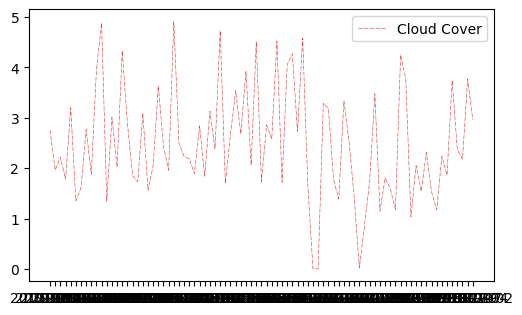

In [6]:
fig = plt.figure(dpi=100)
fig.autofmt_xdate()
ax = fig.add_subplot(1, 1, 1)
ax.plot(dates, cloudcover, label="Cloud Cover", color="tab:red", linewidth=0.4, linestyle="-.")

ax.legend()

## Use Titiler endpoint

https://api.cogeo.xyz/docs#/SpatioTemporal%20Asset%20Catalog

`{endpoint}/stac/tiles/{z}/{x}/{y}.{format}?url={stac_item}&{otherquery params}`


`{endpoint}/stac/crop/{minx},{miny},{maxx},{maxy}.{format}?url={stac_item}&{otherquery params}`


`{endpoint}/stac/point/{minx},{miny}?url={stac_item}&{otherquery params}`


In [7]:
url_template = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/{id}"

### Visualize One Item

In [8]:
# Get Tile URL
r = requests.get(
    f"{titiler_endpoint}/stac/tilejson.json",
    params = {
        "url": url_template.format(id=sceneid[0]),
        "assets": "B04,B03,B02",  # Simple RGB combination (True Color)
        "color_formula": "Gamma RGB 3.5 Saturation 1.7 Sigmoidal RGB 15 0.35",  # We use a rio-color formula to make the tiles look nice
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)

m = Map(
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=10
)

tiles = TileLayer(
    url=r["tiles"][0],
    min_zoom=r["minzoom"],
    max_zoom=r["maxzoom"],
    opacity=1
)
m.add_layer(tiles)
m

{'tilejson': '2.2.0', 'name': 'S2B_36RTT_20191205_0_L2A', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://api.cogeo.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv0%2Fcollections%2Fsentinel-s2-l2a-cogs%2Fitems%2FS2B_36RTT_20191205_0_L2A&assets=B04%2CB03%2CB02&color_formula=Gamma+RGB+3.5+Saturation+1.7+Sigmoidal+RGB+15+0.35'], 'minzoom': 8, 'maxzoom': 14, 'bounds': [30.155974613579858, 28.80949327971016, 31.050481437029678, 29.815791988006527], 'center': [30.603228025304766, 29.312642633858346, 8]}


Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [9]:
r = requests.get(
    f"{titiler_endpoint}/stac/tilejson.json",
    params = {
        "url": url_template.format(id=sceneid[0]),
        "assets": "B08,B04,B03",  # False Color Infrared
        "color_formula": "Gamma RGB 3.5 Saturation 1.7 Sigmoidal RGB 15 0.35",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)

m = Map(
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=10
)

tiles = TileLayer(
    url=r["tiles"][0],
    min_zoom=r["minzoom"],
    max_zoom=r["maxzoom"],
    opacity=1
)
m.add_layer(tiles)
m

{'tilejson': '2.2.0', 'name': 'S2B_36RTT_20191205_0_L2A', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://api.cogeo.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv0%2Fcollections%2Fsentinel-s2-l2a-cogs%2Fitems%2FS2B_36RTT_20191205_0_L2A&assets=B08%2CB04%2CB03&color_formula=Gamma+RGB+3.5+Saturation+1.7+Sigmoidal+RGB+15+0.35'], 'minzoom': 8, 'maxzoom': 14, 'bounds': [30.155974613579858, 28.80949327971016, 31.050481437029678, 29.815791988006527], 'center': [30.603228025304766, 29.312642633858346, 8]}


Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [10]:
r = requests.get(
    f"{titiler_endpoint}/stac/tilejson.json",
    params = {
        "url": url_template.format(id=sceneid[0]),
        "expression": "(B08-B04)/(B08+B04)",  # NDVI
        "rescale": "-1,1",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
        "color_map": "viridis",
    }
).json()
print(r)

m = Map(
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=10
)

tiles = TileLayer(
    url=r["tiles"][0],
    min_zoom=r["minzoom"],
    max_zoom=r["maxzoom"],
    opacity=1
)
m.add_layer(tiles)
m

{'tilejson': '2.2.0', 'name': 'S2B_36RTT_20191205_0_L2A', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://api.cogeo.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv0%2Fcollections%2Fsentinel-s2-l2a-cogs%2Fitems%2FS2B_36RTT_20191205_0_L2A&expression=%28B08-B04%29%2F%28B08%2BB04%29&rescale=-1%2C1&color_map=viridis'], 'minzoom': 8, 'maxzoom': 14, 'bounds': [30.155974613579858, 28.80949327971016, 31.050481437029678, 29.815791988006527], 'center': [30.603228025304766, 29.312642633858346, 8]}


Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

# More

titiler doesn't return only png or jpeg but can also return Numpy array directly

In [13]:
def fetch_bbox_array(sceneid, bbox, assets = None, expression = None, **kwargs):
    """Helper function to fetch and decode Numpy array using Titiler endpoint."""
    # STAC ITEM URL
    stac_item = f"https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/{sceneid}"

    xmin, ymin, xmax, ymax = bbox
    
    # TiTiler required URL + asset or expression parameters
    params = {"url": stac_item}
    if assets:
        params.update(dict(assets=",".join(assets)))
    elif expression:
        params.update(dict(expression=expression))
    else:
        raise Exception("Missing band or expression input")

    params.update(**kwargs)

    # TITILER ENDPOINT
    url = f"{titiler_endpoint}stac/crop/{xmin},{ymin},{xmax},{ymax}.npy"
    r = requests.get(url, params=params)
    data = numpy.load(BytesIO(r.content))
    
    return sceneid, data[0:-1], data[-1]

def _filter_futures(tasks):
    for future in tasks:
        try:
            yield future.result()
        except Exception:
            pass

def _stats(data, mask):
    arr = numpy.ma.array(data)
    arr.mask = mask == 0
    return arr.min().item(), arr.max().item(), arr.mean().item(), arr.std().item()

(1, 128, 128)
(128, 128)


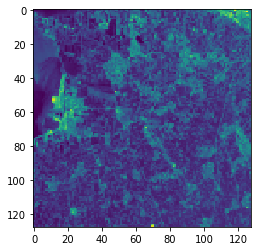

In [14]:
# Fetch one data
_, data, mask = fetch_bbox_array(sceneid[0], bounds, assets=["B02"], width=128, height=128)

print(data.shape)
print(mask.shape)

imshow(data[0])


diplay all results


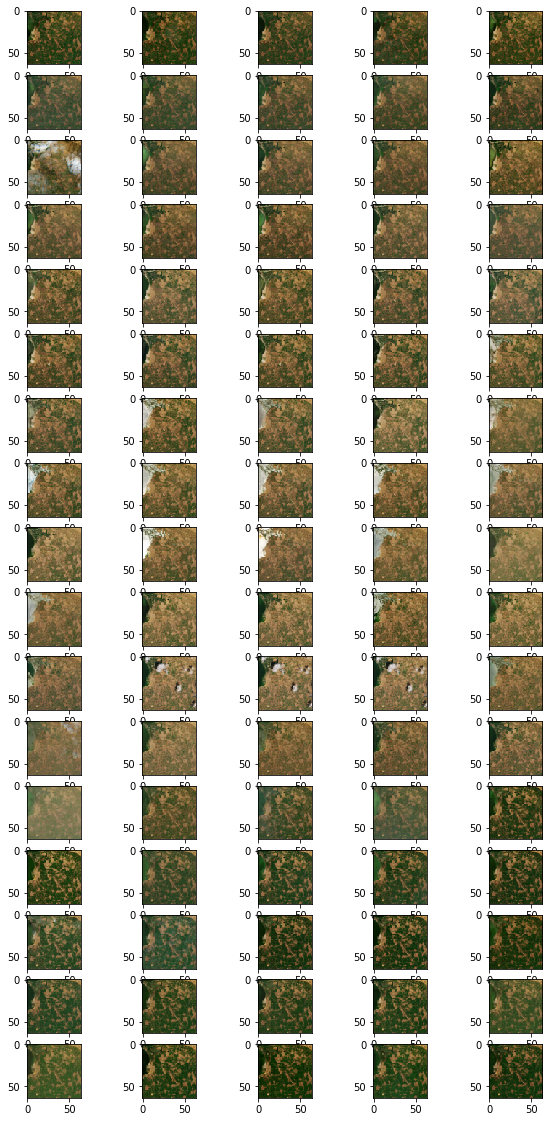

In [15]:
# Let's fetch the data over our AOI for all our Items
# Here we use `futures.ThreadPoolExecutor` to run the requests in parallel
# Note: it takes more time for the notebook to display the results than to fetch the data

bbox_worker = partial(
    fetch_bbox_array,
    bbox=bounds,
    assets=("B04", "B03", "B02"), 
    color_formula="gamma RGB 3.5, saturation 1.7, sigmoidal RGB 15 0.35",
    width=64,
    height=64,
)

with futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_work = [
        executor.submit(bbox_worker, scene) for scene in sceneid
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

results_rgb  = list(_filter_futures(future_work))

print("diplay all results")

fig = plt.figure(figsize=(10,20))
col = 5
row = math.ceil(len(dates) / col)
for i in range(1, len(results_rgb) + 1):
    fig.add_subplot(row, col, i)
    plt.imshow(reshape_as_image(results_rgb[i-1][1]))

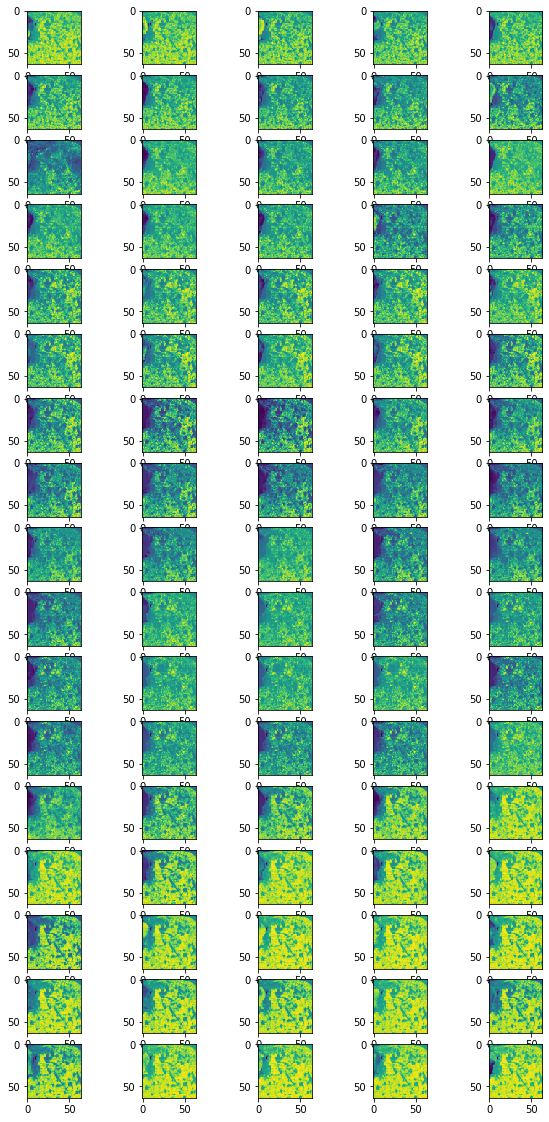

In [16]:
## Fetch NDVI

bbox_worker = partial(
    fetch_bbox_array,
    bbox=bounds,
    expression="(B08-B04)/(B08+B04)",
    width=64,
    height=64,
)

with futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_work = [
        executor.submit(bbox_worker, scene) for scene in sceneid
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

results_ndvi  = list(_filter_futures(future_work))

fig = plt.figure(figsize=(10,20))
col = 5
row = math.ceil(len(dates) / col)
for i in range(1, len(results_rgb) + 1):
    fig.add_subplot(row, col, i)
    plt.imshow(results_ndvi[i-1][1][0])

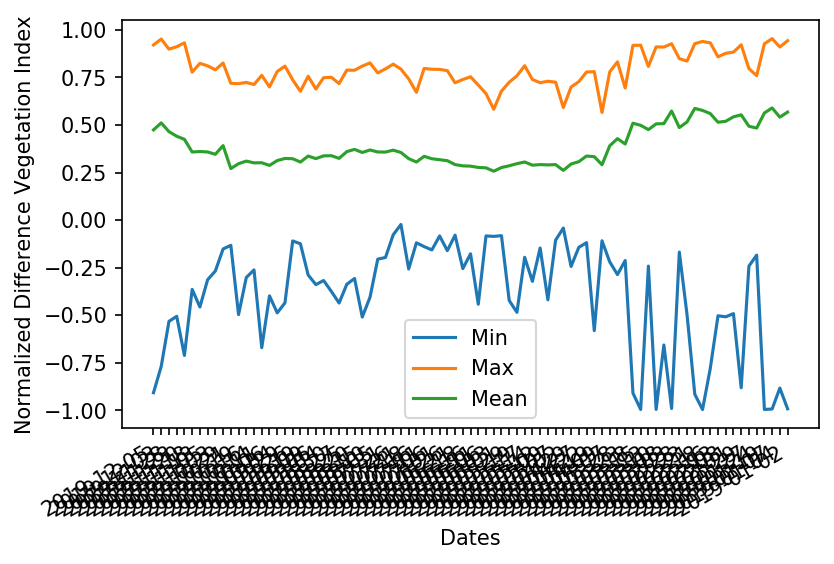

In [17]:
stats = [_stats(data, mask) for _, data, mask in results_ndvi]

fig, ax1 = plt.subplots(dpi=150)
fig.autofmt_xdate()

ax1.plot(dates, [s[0] for s in stats], label="Min")
ax1.plot(dates, [s[1] for s in stats], label="Max")
ax1.plot(dates, [s[2] for s in stats], label="Mean")
ax1.set_xlabel("Dates")
ax1.set_ylabel("Normalized Difference Vegetation Index")

ax1.legend()